## Set-up and data loading

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from ipywidgets import interactive, fixed
import warnings

from lib import data, visualization

sns.set()

%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
data.download_data()

The data is already downloaded.


In [3]:
header, dtype_dict = data.get_data_header_and_dtypes()
learn_df = pd.read_csv(
    "data/us_census_full/census_income_learn.csv",
    names=header,
    usecols=[i for i in range(42) if i != 24],
    dtype=dtype_dict,
    sep=", ",
    engine="python",
)
test_df = pd.read_csv(
    "data/us_census_full/census_income_test.csv",
    names=header,
    usecols=[i for i in range(42) if i != 24],
    dtype=dtype_dict,
    sep=", ",
    engine="python",
)

In [4]:
numerical_cols = list(learn_df.columns[learn_df.dtypes == int])
categorical_cols = list(learn_df.columns[learn_df.dtypes == "category"])

## Exploratory data analysis

In [5]:
print(f"Entries in learn data: {len(learn_df)}")
print(f"Entries in test data: {len(test_df)}")

Entries in learn data: 199523
Entries in test data: 99762


In [6]:
print("Proportions of missing values:")
missing_values = pd.concat(
    [(learn_df == "?").sum() / len(learn_df), (test_df == "?").sum() / len(test_df)],
    axis=1,
).rename(columns={0: "learn", 1: "test"})
missing_values[missing_values.sum(axis=1) > 0]

Proportions of missing values:


,learn,test
state of previous residence,0.003548,0.003308
migration code-change in msa,0.499672,0.500652
migration code-change in reg,0.499672,0.500652
migration code-move within reg,0.499672,0.500652
migration prev res in sunbelt,0.499672,0.500652
country of birth father,0.033645,0.034372
country of birth mother,0.030668,0.030793
country of birth self,0.017006,0.017682


In [7]:
print("Proportions of undefined values:")
unknown_values = pd.concat(
    [
        learn_df.isin(["Not in universe", "Do not know", "NA", "All other"]).sum()
        / len(learn_df),
        test_df.isin(["Not in universe", "Do not know", "NA", "All other"]).sum()
        / len(test_df),
    ],
    axis=1,
).rename(columns={0: "learn", 1: "test"})
unknown_values[unknown_values.sum(axis=1) > 0]

Proportions of undefined values:


,learn,test
class of worker,0.502423,0.501985
enroll in edu inst last wk,0.936950,0.936469
major occupation code,0.504624,0.504030
hispanic origin,0.863124,0.862683
member of a labor union,0.904452,0.904984
reason for unemployment,0.969577,0.968625
region of previous residence,0.920946,0.922876
state of previous residence,0.920946,0.922876
migration code-change in msa,0.007598,0.007247
migration code-change in reg,0.007598,0.007247


In [8]:
learn_df["set"] = "learn"
test_df["set"] = "test"
learn_test_df = pd.concat([learn_df, test_df])

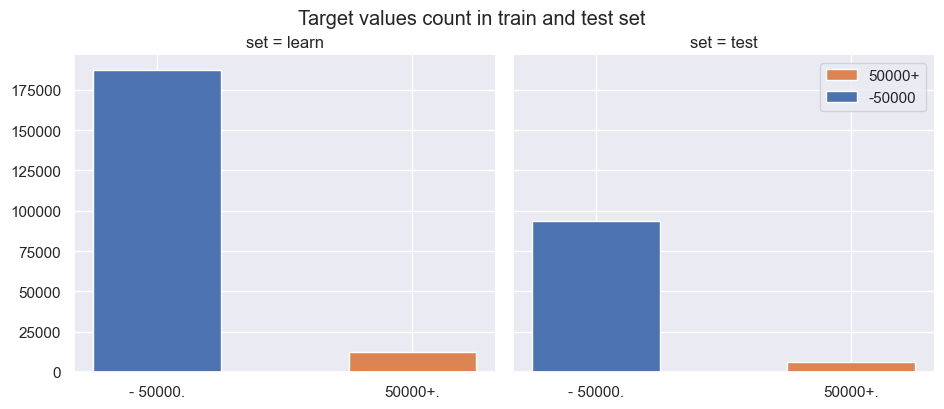

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # Annoying seaborn warning

    g = sns.FacetGrid(learn_test_df, col="set", height=4, aspect=1.2)  # type: ignore
    g.map_dataframe(
        sns.histplot,
        x="target",
        hue="target",
        stat="count",
        legend=True,
        shrink=0.5,
        alpha=1,
    )
    plt.legend(["50000+", "-50000"])
    plt.suptitle("Target values count in train and test set", y=1.02)
    plt.show()

In [13]:
interactive(
    visualization.plot_variable_histograms,
    df=fixed(learn_test_df),
    variable=numerical_cols,
)

interactive(children=(Dropdown(description='variable', options=('age', 'wage per hour', 'capital gains', 'capi…

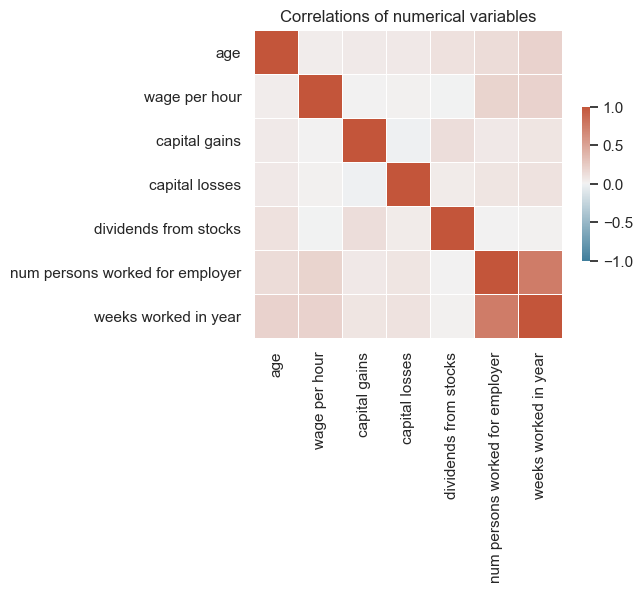

In [15]:
corr = learn_test_df[numerical_cols].corr()

_, ax = plt.subplots(figsize=(5, 4))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr,
    cmap=cmap,
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)
plt.title("Correlations of numerical variables")
plt.show()

In [16]:
interactive(
    visualization.plot_variable_histograms,
    df=fixed(learn_test_df),
    variable=categorical_cols,
)

interactive(children=(Dropdown(description='variable', options=('class of worker', 'detailed industry recode',…

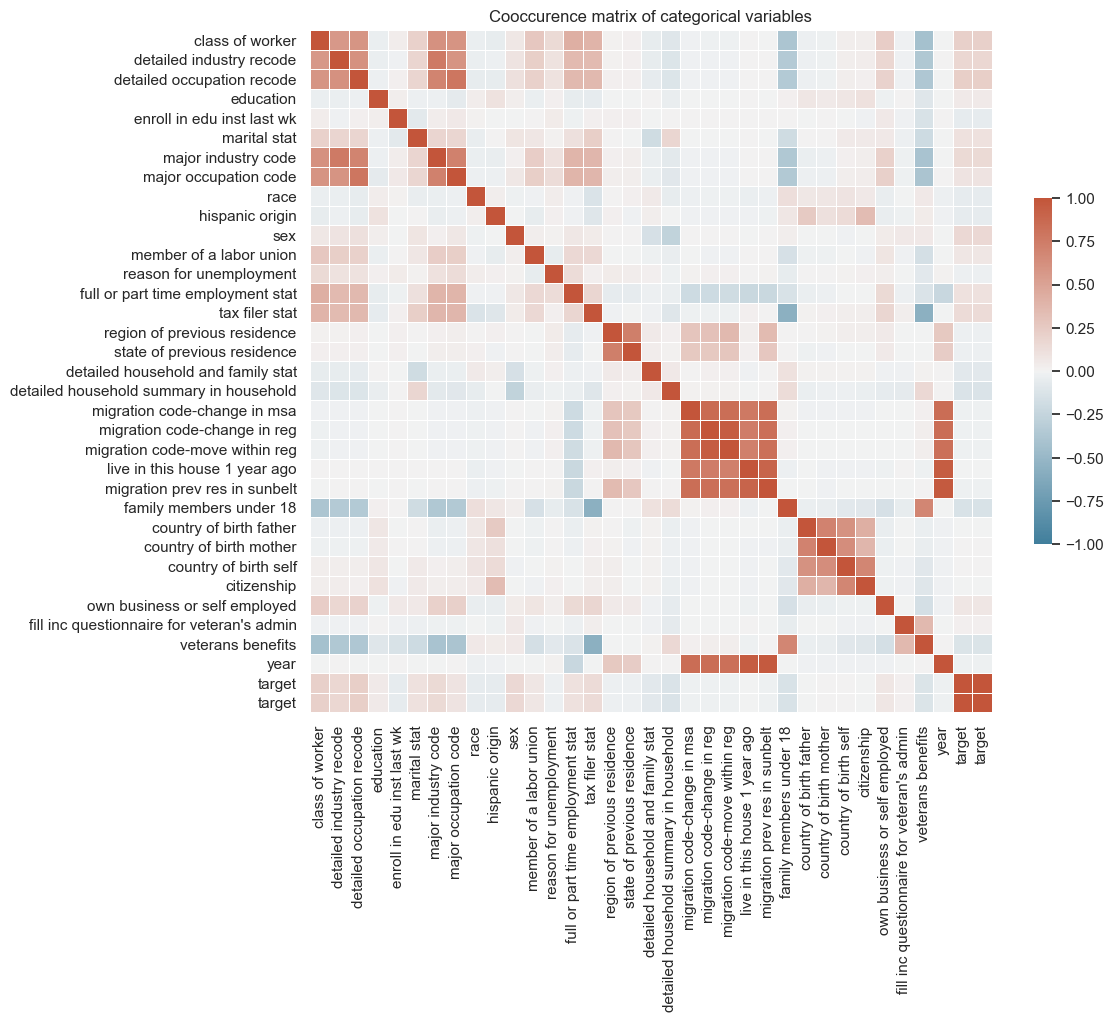

In [17]:
cooc = (
    learn_test_df[categorical_cols + ["target"]]
    .apply(lambda x: pd.factorize(x)[0])
    .corr(method="pearson", min_periods=1)
)

_, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    cooc,
    cmap=cmap,
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)
plt.title("Cooccurence matrix of categorical variables")
plt.show()

## Data modeling

In [42]:
# TODO: certaines features sont peut-être à laisser (ex: class of worker)
categorical_features = [
    "class of worker",
    "detailed industry recode",
    "detailed occupation recode",
    "education",
    # "enroll in edu inst last wk",
    "marital stat",
    "major industry code",
    "major occupation code",
    "race",
    # "hispanic origin",
    "sex",
    # "member of a labor union",
    # "reason for unemployment",
    "full or part time employment stat",
    "tax filer stat",
    # "region of previous residence",
    # "state of previous residence",
    # "detailed household and family stat", TODO: a garder ? ou feature d'en dessous équivalente ?
    "detailed household summary in household",
    # "migration code-change in msa",
    # "migration code-change in reg",
    # "migration code-move within reg",
    "live in this house 1 year ago",
    # "migration prev res in sunbelt",
    # "family members under 18",
    "country of birth father",
    "country of birth mother",
    "country of birth self",
    "citizenship",
    "own business or self employed",
    # "fill inc questionnaire for veteran's admin",
    "veterans benefits",
    "year",
]

numerical_features = [
    "age",
    "wage per hour",
    "capital gains",
    "capital losses",
    "dividends from stocks",
    "num persons worked for employer",
    "weeks worked in year",
]

In [43]:
X_train = learn_df[categorical_features + numerical_features].copy()
y_train = learn_df["target"]
X_test = test_df[categorical_features + numerical_features].copy()
y_test = test_df["target"].to_frame()

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import metrics
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

In [45]:
RANDOM_SEED = 2910

In [46]:
# Logistic regression pipeline
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_SEED,
)
lr_ct = ColumnTransformer(
    [
        (
            "scaler",
            StandardScaler(),
            numerical_features,
        ),
        (
            "onehot",
            OneHotEncoder(),
            categorical_features,
        ),
    ],
    remainder="passthrough",
)

lr_pipeline = Pipeline(
    steps=[
        ("col_trans", lr_ct),
        (
            "model",
            lr,
        ),
    ]
)

# Decision tree pipeline
dt = DecisionTreeClassifier(
    class_weight="balanced",
    random_state=RANDOM_SEED,
)
dt_ct = ColumnTransformer(
    [
        (
            "onehot",
            OneHotEncoder(),
            categorical_features,
        ),
    ],
    remainder="passthrough",
)

dt_pipeline = Pipeline(
    steps=[
        ("col_trans", dt_ct),
        (
            "model",
            dt,
        ),
    ]
)

# Histogram gradient boosting pipeline
hgb = HistGradientBoostingClassifier(
    categorical_features=[X_train.columns.get_loc(col) for col in categorical_features],
    max_iter=500,
    class_weight="balanced",
    random_state=RANDOM_SEED,
)
hgb_ct = ColumnTransformer(
    [
        (
            "ordinal",
            OrdinalEncoder(),
            categorical_features,
        ),
    ],
    remainder="passthrough",
)

hgb_pipeline = Pipeline(
    steps=[
        ("col_trans", hgb_ct),
        (
            "model",
            hgb,
        ),
    ]
)

In [47]:
metrics_df = pd.DataFrame()
for model_name, pipeline in [
    ("logistic regression", lr_pipeline),
    ("decision tree", dt_pipeline),
    ("histogram gradient boosting", hgb_pipeline),
]:
    print(f"Training {model_name}...")
    pipeline.fit(X_train, y_train)
    y_test[f"pred_{model_name}"] = pipeline.predict(X_test)

    precision, recall, f1, support = metrics.precision_recall_fscore_support(
        y_test["target"],
        y_test[f"pred_{model_name}"],
        average="binary",
        pos_label="50000+.",
    )
    metrics_df.loc[
        model_name, ["precision (50000+)", "recall(50000+)", "f1_score(50000+)"]
    ] = [
        precision,
        recall,
        f1,
    ]
    precision, recall, f1, support = metrics.precision_recall_fscore_support(
        y_test["target"],
        y_test[f"pred_{model_name}"],
        average="binary",
        pos_label="- 50000.",
    )
    metrics_df.loc[
        model_name, ["precision (-50000)", "recall(-50000)", "f1_score(-50000)"]
    ] = [
        precision,
        recall,
        f1,
    ]
    metrics_df.loc[model_name, "accuracy"] = metrics.accuracy_score(
        y_test["target"],
        y_test[f"pred_{model_name}"],
    )
    metrics_df.loc[model_name, "error_rate"] = (
        y_test["target"] != y_test[f"pred_{model_name}"]
    ).sum() / len(y_test)

Training logistic regression...
Training decision tree...
Training histogram gradient boosting...


## Model assessment

In [48]:
metrics_df

,precision (50000+),recall(50000+),f1_score(50000+),precision (-50000),recall(-50000),f1_score(-50000),accuracy,error_rate
logistic regression,0.286292,0.892014,0.433464,0.991701,0.852996,0.917134,0.855416,0.144584
decision tree,0.441385,0.482056,0.460825,0.965551,0.959669,0.962601,0.930054,0.069946
histogram gradient boosting,0.334737,0.886680,0.486000,0.991592,0.883506,0.934434,0.883703,0.116297


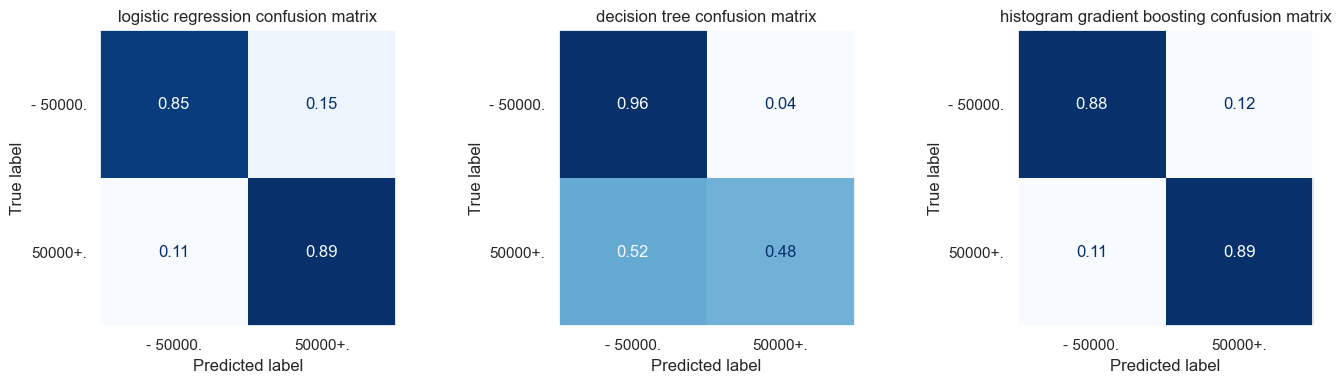

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay

_, axs = plt.subplots(1, 3, figsize=(14, 4))
for i, model_name in enumerate(
    [
        "logistic regression",
        "decision tree",
        "histogram gradient boosting",
    ]
):
    ConfusionMatrixDisplay.from_predictions(
        y_test["target"],
        y_test[f"pred_{model_name}"],
        normalize="true",
        colorbar=False,
        cmap=plt.cm.Blues,  # type: ignore
        ax=axs[i],
    )
    axs[i].set_title(f"{model_name} confusion matrix")
    axs[i].grid(False)

plt.tight_layout()

## Results & insights

In [50]:
import shap

In [51]:
X_train_sample = X_train.sample(10000)

explainer = shap.TreeExplainer(hgb_pipeline["model"])  # type: ignore
shap_values = explainer.shap_values(hgb_pipeline["col_trans"].transform(X_train_sample))  # type: ignore

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


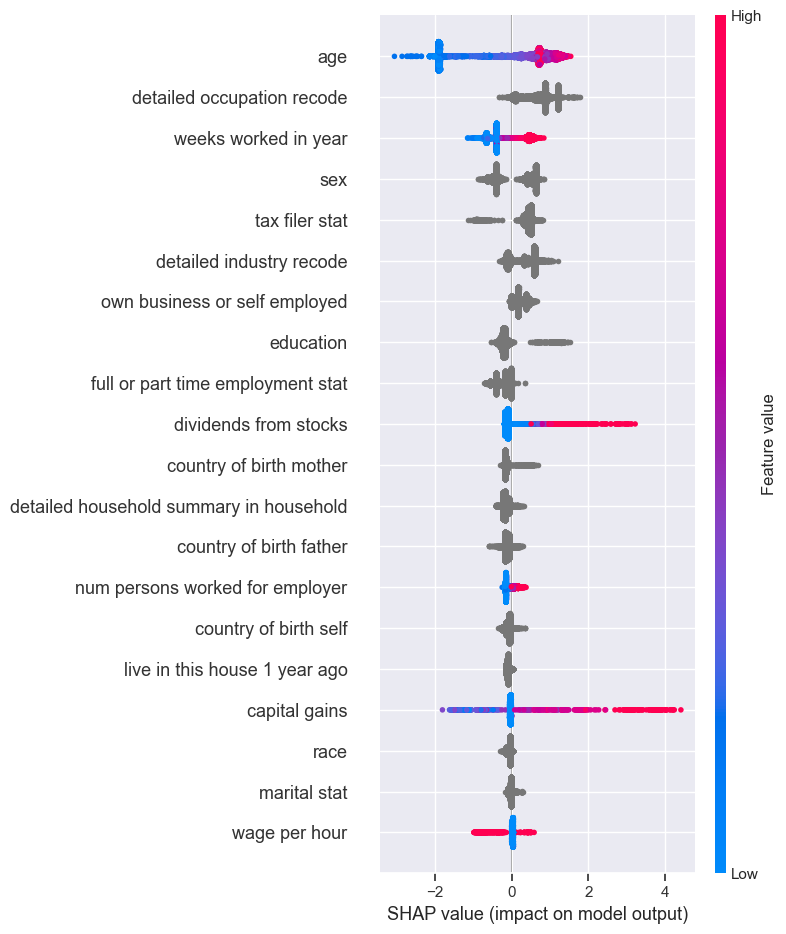

In [55]:
shap.summary_plot(shap_values, X_train_sample, plot_type="dot")